In [1]:
from cleanlab.filter_copy import find_label_issues_bench, find_label_issues_cow, find_label_issues_naive, find_label_issues_numba

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [3]:
def normalize(arr): 
    normalized = np.zeros(arr.shape, dtype=np.float16) 
    for i, a in enumerate(arr): 
        normalized[i] = a / np.sum(a) 
    return normalized 

In [4]:
colormap = plt.cm.rainbow

In [5]:
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)]
#n_m = [(50, 1000)]

In [6]:
nt = 9
ncores = 10

In [7]:
runtimes = np.zeros((len(n_m), ncores, nt))
runtimes_cow = np.zeros((len(n_m), ncores, nt))
runtimes_naive = np.zeros((len(n_m), ncores, nt))
runtimes_numba = np.zeros((len(n_m), ncores, nt))

In [8]:
np.random.seed(0) 

In [9]:
import multiprocessing
multiprocessing.set_start_method('fork')

# careful benchmarking

In [10]:
# we need to do a dummy computation to compile numba code
n = 100
m = 5
pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
pred_probs = normalize(pred_probs) 
labels = np.repeat(np.arange(m), n // m) 
_, _ = find_label_issues_numba(pred_probs=pred_probs, labels=labels, n_jobs=1)

In [11]:
for i, nm in enumerate(n_m): # varying number of classes 
    print(f"starting pair {nm}")
    n = nm[1]
    m = nm[0]
    pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
    pred_probs = normalize(pred_probs) 
    labels = np.repeat(np.arange(m), n // m) 
    for n_jobs in range(ncores): 
        print(f"n_jobs {n_jobs+1}")
        # original implementation
        #issues, times = find_label_issues_bench(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes[i, n_jobs, :] = times
        
        # cow
        issues_cow, times_cow = find_label_issues_cow(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes_cow[i, n_jobs, :] = times_cow
        
        # naive implementation with fork
        #issues_naive, times_naive = find_label_issues_naive(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes_naive[i, n_jobs, :] = times_naive
        
        # numba
        #issues_numba, times_numba = find_label_issues_numba(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes_numba[i, n_jobs, :] = times_numba
        
        # check everyone got the same answer
        #diff1 = np.sum(issues ^ issues_cow)
        #if diff1 != 0:
        #    print(f"original and cow don't match on {diff1}")
        #diff2 = np.sum(issues_cow ^ issues_naive)
        #if diff2 != 0:
        #    print(f"cow and naive don't match on {diff2}")
        #diff3 = np.sum(issues_naive ^ issues_numba)
        #if diff3 != 0:
        #    print(f"numba and naive don't match on {diff3}")
        #diff4 = np.sum(issues ^ issues_numba)
        #if diff4 != 0:
        #    print(f"original and numba don't match on {diff4}")
    print(f"finished pair {nm}") 

#np.save("vary_nm_original.npy", runtimes)
np.save("vary_nm_cow.npy", runtimes_cow)
#np.save("vary_nm_naive.npy", runtimes_naive)
#np.save("vary_nm_numba.npy", runtimes_numba)

starting pair (5000, 20000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 20000)
starting pair (5000, 40000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 40000)
starting pair (5000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 60000)
starting pair (10000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (10000, 60000)
starting pair (15000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (15000, 60000)


In [14]:
runtimes_numba = np.load("vary_nm_numba.npy")

In [12]:
runtime_totals = np.cumsum(runtimes_cow, axis=-1)

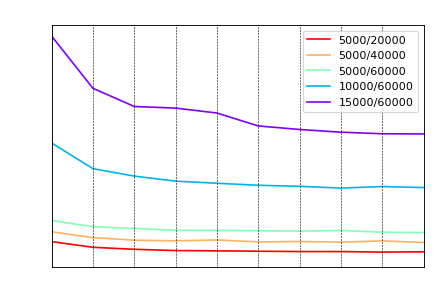

In [15]:
runtime_t_numba = np.cumsum(runtimes_numba, axis=-1)
colormap = plt.cm.rainbow 
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

plt.figure(figsize=(6, 4), dpi=80) 
for i, runtime in enumerate(runtime_totals[..., -1]): 
    plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
for x in range(10): 
    plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
plt.legend() 
plt.xticks(np.arange(10)+1) 
plt.xlim([1, 10]) 
plt.xlabel('n_jobs', c='w') 
plt.ylabel('Time (sec)', c='w') 
plt.ylim(bottom=0) 
plt.title('total times with varying m/n', c='w') 
plt.tick_params(colors='w')
plt.show() 

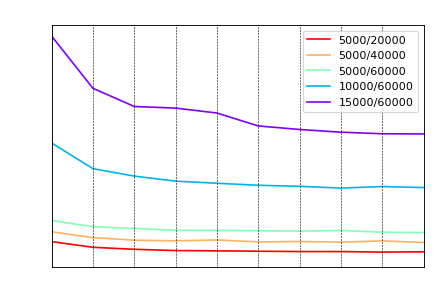

In [13]:
colormap = plt.cm.rainbow 
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

plt.figure(figsize=(6, 4), dpi=80) 
for i, runtime in enumerate(runtime_totals[..., -1]): 
    plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
for x in range(10): 
    plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
plt.legend() 
plt.xticks(np.arange(10)+1) 
plt.xlim([1, 10]) 
plt.xlabel('n_jobs', c='w') 
plt.ylabel('Time (sec)', c='w') 
plt.ylim(bottom=0) 
plt.title('total times with varying m/n', c='w') 
plt.tick_params(colors='w')
plt.show() 

In [12]:
ckpt_names = ['initial checks', 'calc confident joint', 'preproc for prune', 'load to RawArray for multiproc', 'prune by class', 'prune by count', 'confident learning', 'pred neq', 'final processing']

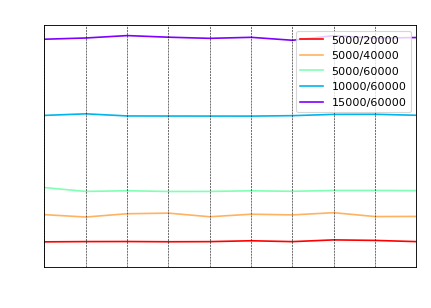

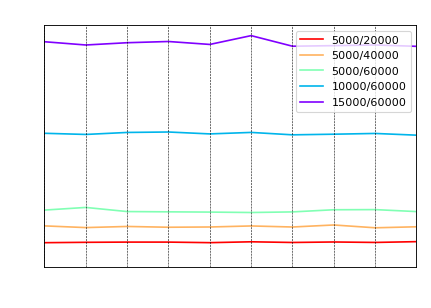

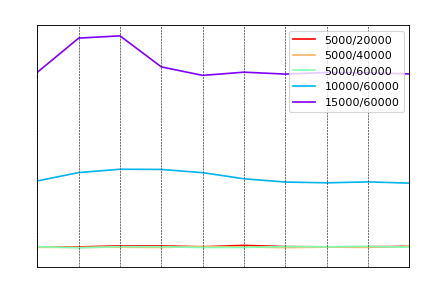

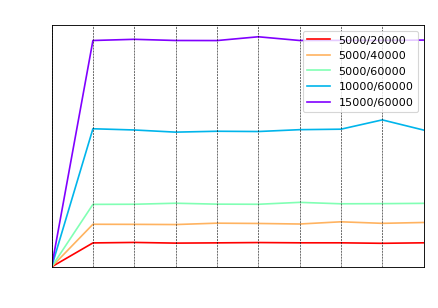

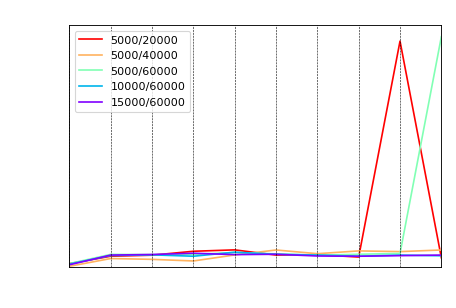

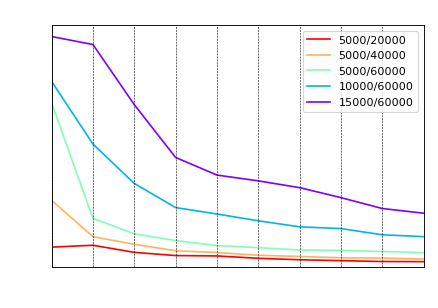

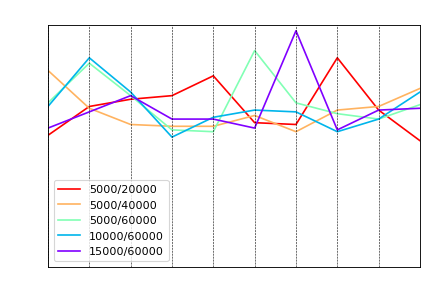

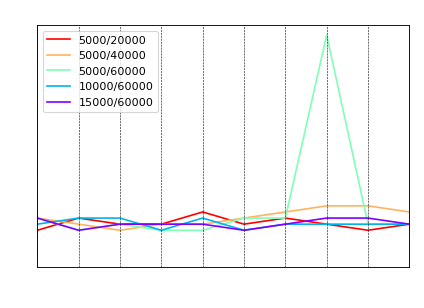

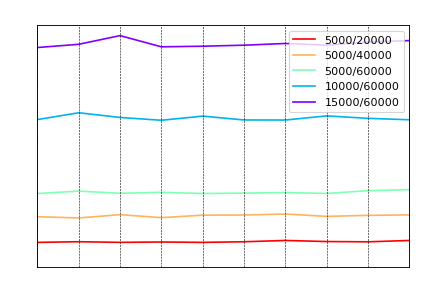

In [34]:
for check_pt in range(nt):
    colormap = plt.cm.rainbow 
    n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
    colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

    plt.figure(figsize=(6, 4), dpi=80) 
    for i, runtime in enumerate(runtimes[..., check_pt]): 
        plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    plt.legend() 
    plt.xticks(np.arange(10)+1) 
    plt.xlim([1, 10]) 
    plt.xlabel('n_jobs', c='w') 
    plt.ylabel('Time (sec)', c='w') 
    plt.ylim(bottom=0) 
    plt.title(f'{ckpt_names[check_pt]} with varying m/n', c='w') 
    plt.tick_params(colors='w')
    plt.show() 

# benchmarking cow

## debugging cow

I've debugged cow and it seems to be working for prune by count

In [9]:
# cow seems to give different outputs than eveyone else
n = 20
m = 5
pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
pred_probs = normalize(pred_probs) 
labels = np.repeat(np.arange(m), n // m) 

In [10]:
issues, _ = find_label_issues_bench(pred_probs=pred_probs, labels=labels, n_jobs=1) 

# cow
issues_cow, _ = find_label_issues_cow(pred_probs=pred_probs, labels=labels, n_jobs=1) 

# naive implementation with fork
issues_naive, _ = find_label_issues_naive(pred_probs=pred_probs, labels=labels, n_jobs=1) 

# numba
#issues_numba, _ = find_label_issues_numba(pred_probs=pred_probs, labels=labels, n_jobs=1) 

In [11]:
issues

array([ True, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True])

In [12]:
issues_cow

array([ True, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True])

In [13]:
issues_naive

array([ True, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True])

In [16]:
issues_numba

array([ True,  True, False, False, False, False, False,  True, False,
        True,  True, False,  True,  True, False,  True,  True, False,
        True, False])

## cow plots

In [11]:
np.random.seed(0) 
for i, nm in enumerate(n_m): # varying number of classes 
    print(f"starting pair {nm}")
    n = nm[1]
    m = nm[0]
    pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
    pred_probs = normalize(pred_probs) 
    labels = np.repeat(np.arange(m), n // m) 
    for n_jobs in range(ncores): 
        print(f"n_jobs {n_jobs+1}")
        _, times = find_label_issues_cow(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes[i, n_jobs, :] = times
    print(f"finished pair {nm}") 
    
np.save('cow_varying_nm.npy', runtimes) 

starting pair (5000, 20000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 20000)
starting pair (5000, 40000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 40000)
starting pair (5000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 60000)
starting pair (10000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (10000, 60000)
starting pair (15000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (15000, 60000)


In [13]:
runtime_totals = np.cumsum(runtimes, axis=-1)

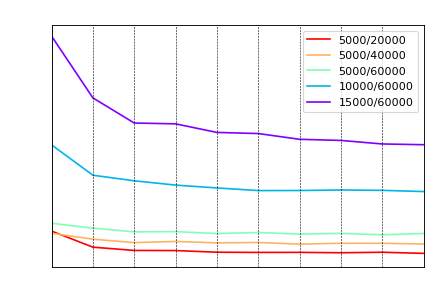

In [14]:
colormap = plt.cm.rainbow 
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

plt.figure(figsize=(6, 4), dpi=80) 
for i, runtime in enumerate(runtime_totals[..., -1]): 
    plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
for x in range(10): 
    plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
plt.legend() 
plt.xticks(np.arange(10)+1) 
plt.xlim([1, 10]) 
plt.xlabel('n_jobs', c='w') 
plt.ylabel('Time (sec)', c='w') 
plt.ylim(bottom=0) 
plt.title('total times with varying m/n', c='w') 
plt.tick_params(colors='w')
plt.show() 

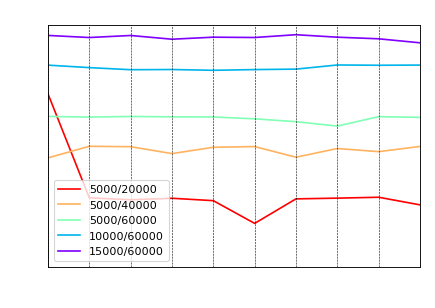

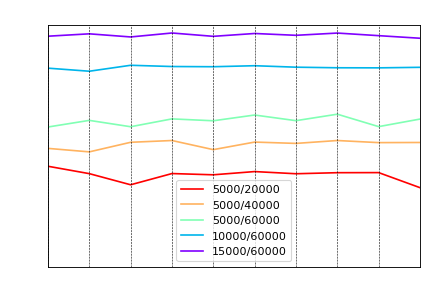

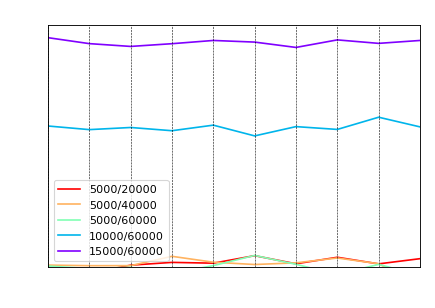

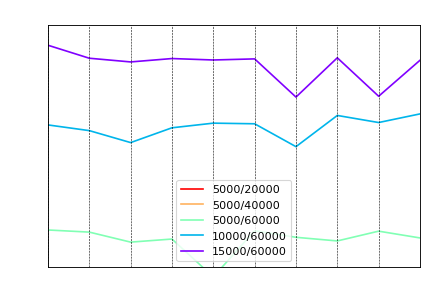

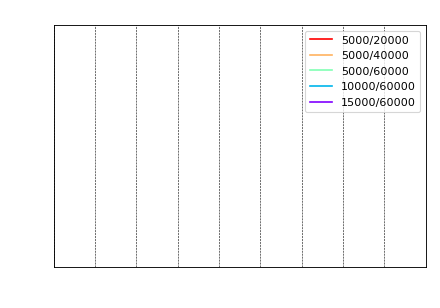

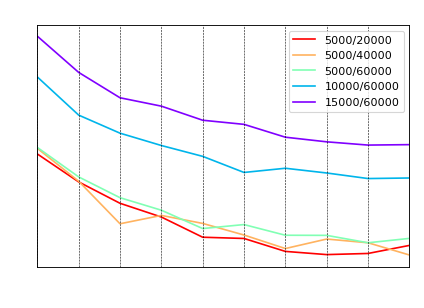

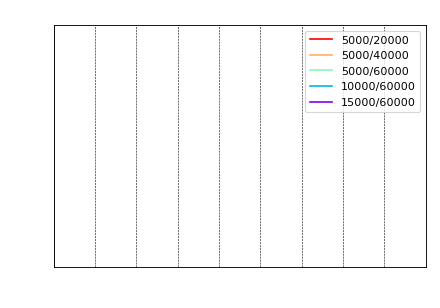

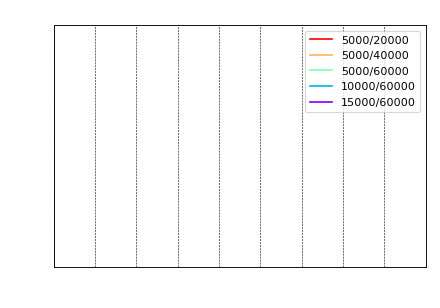

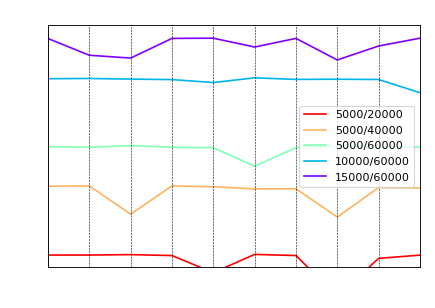

In [16]:
for check_pt in range(nt):
    colormap = plt.cm.rainbow 
    n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
    colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

    plt.figure(figsize=(6, 4), dpi=80) 
    for i, runtime in enumerate(runtimes[..., check_pt]): 
        plt.plot(np.arange(10)+1, np.log(runtime), label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    plt.legend() 
    plt.xticks(np.arange(10)+1) 
    plt.xlim([1, 10]) 
    plt.xlabel('n_jobs', c='w') 
    plt.ylabel('Time (sec)', c='w') 
    plt.ylim(bottom=0) 
    plt.title(f'{ckpt_names[check_pt]} with varying m/n', c='w') 
    plt.tick_params(colors='w')
    plt.show() 

# old visualization

In [30]:
m = 5000
n = 50000

In [31]:
pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
pred_probs = normalize(pred_probs) 
labels = np.repeat(np.arange(m), n // m) 

In [32]:
nt = 9
ncores = 10
time_ints = np.zeros((9, 10))

In [33]:
for n_jobs in range(10):
    print(f"njob {n_jobs}")
    _, times = find_label_issues_bench(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1)
    time_ints[:, n_jobs] = times

njob 0
njob 1
njob 2
njob 3
njob 4
njob 5
njob 6
njob 7
njob 8
njob 9


In [34]:
time_totals = np.sum(time_ints, axis=0)

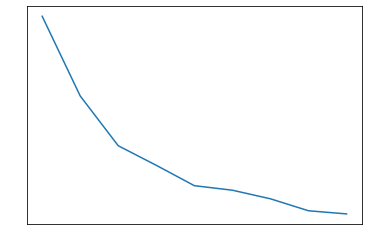

In [38]:
plt.plot(time_totals[1:])
plt.tick_params(colors='w')

In [11]:
time_ints[3,0]

1.0967254638671875e-05

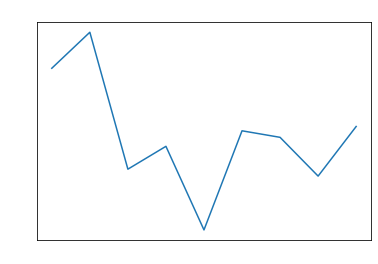

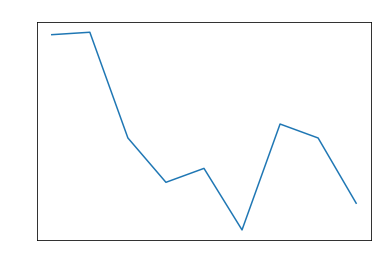

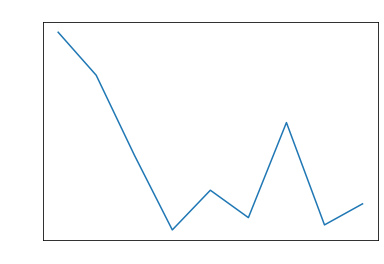

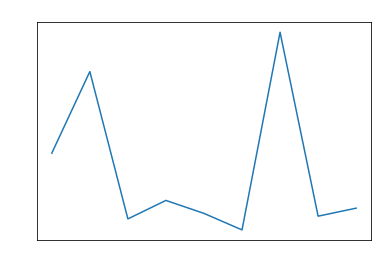

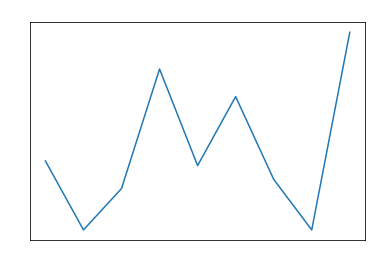

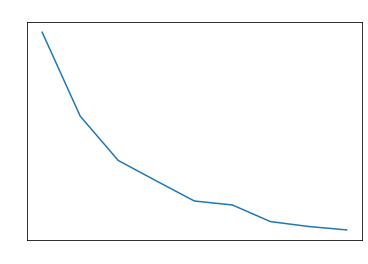

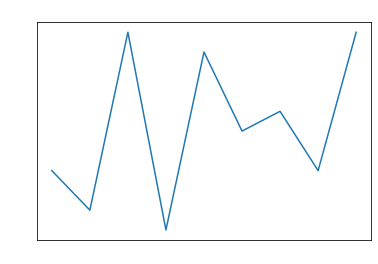

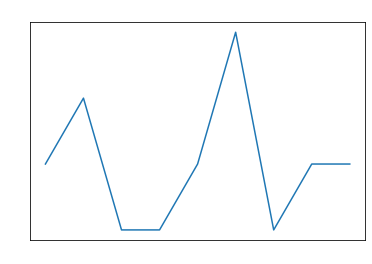

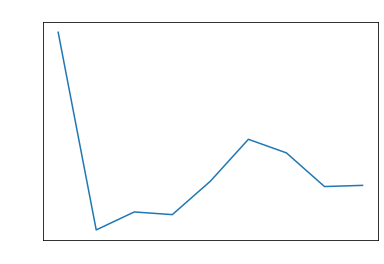

In [37]:
for i in range(nt):
    plt.plot(2+np.arange(ncores-1), time_ints[i,1:])
    plt.title(f"time int {i}", c='w')
    plt.tick_params(colors='w')
    plt.show()

In [18]:
print(f"checks took {times[0]}")
print(f"calculate confident joint took {times[1]}")
print(f"preproc took {times[2]}")
print(f"multiprocess rawarray took {times[3]}")
print(f"prune by class took {times[4]}")
print(f"prune by count took {times[5]}")
print(f"fin conf learn took {times[6]}")
print(f"pre neq took {times[7]}")
print(f"final checks took {times[8]}")

checks took 0.3423280715942383
calculate confident joint took 0.8540129661560059
preproc took 0.2468421459197998
prune by class took 1.4066696166992188e-05
prune by count took 47.77558088302612
fin conf learn took 1.3113021850585938e-05
pre neq took 9.5367431640625e-07
final checks took 0.16227483749389648
